**Проверка гипотиз и глубокий анализ данных**

В прикрепленном ноутбуке в котором обучалась финальная модель, которая получила лучший скор на публичличном лидерборде рассматривались только те гипотезы, которые улучшили результат. Здесь же мы рассмотрим все гипотезы, которые не использовались train.ipynb и покажем проведенный нами глубокий анализ данных. Так как разница в данных, предоставленных для обучения моделей, первого и второго этапа AIIJC заключается лишь в добавлении графа расстояний между подрядчиками, то большая часть анализа данных из первого этапа будет совпадать с анализом со второго этапа.

In [18]:
!pip install pandas catboost scikit-learn xgboost lightgbm numpy==1.24.0 tqdm joblib shap optuna flask feature_engine networkx umap-learn seaborn -q
# после установки - перезапустите окружение

In [1]:
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from tqdm import tqdm
import joblib
import shap
import warnings

In [2]:
X = pd.read_csv('data/train_X.csv')
y = pd.read_csv('data/train_y.csv')
yy = y.copy()

graph = pd.read_csv('data/graph.csv').drop(columns='Unnamed: 0').rename(columns={'contractor_id1': 'contractor_id'})
test = pd.read_csv('data/test2_X.csv')
train = X.merge(y, on=['contract_id', 'report_date'])

**Глубокий анализ данных**

1. Несбалансисорванность датасета:
    Неравное количество случаев дефолта и его отсутствия
    Все значения нормализованны, поэтому построение полимиальных фичей затруднено
    Неравное количество контрактов у каждой из компаний и соответственно разное количество данных по каждой из них
    Большое количество NaN 
2. Исследование датасета:
    Корреляция фичей
    Пересечение трэйна и теста
    Нахождение паттернов
    Кластеризация данных
    Feauture importance
    Features shap values
3. Исследование влияния разных входных данных(разных фичей) в модели
4. Изучение временных рядов и исследование их эффективности
5. Анализ контрактов
6. Продвинутый анализ данных графа расстояний между подрядчиками


    
    
    
    

Распределение дефолта

<BarContainer object of 2 artists>

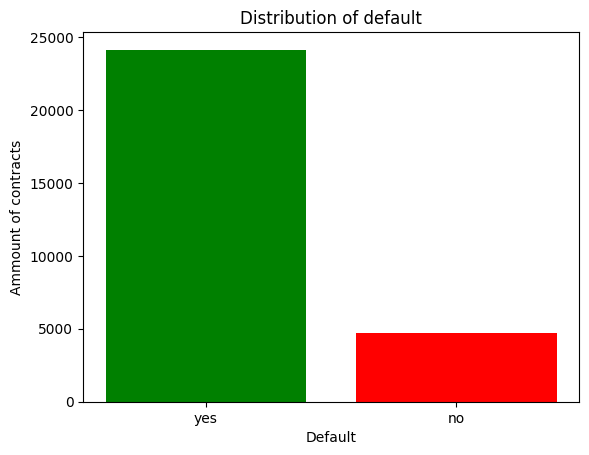

In [3]:
a = y['default6'].to_numpy()
unique, counts = np.unique(a, return_counts=True)
plt.title('Distribution of default')
plt.xlabel('Default')
plt.ylabel('Ammount of contracts')
plt.bar(("yes", "no"), counts, color=['green', 'red'])

Количество контрактов у компаний

<BarContainer object of 646 artists>

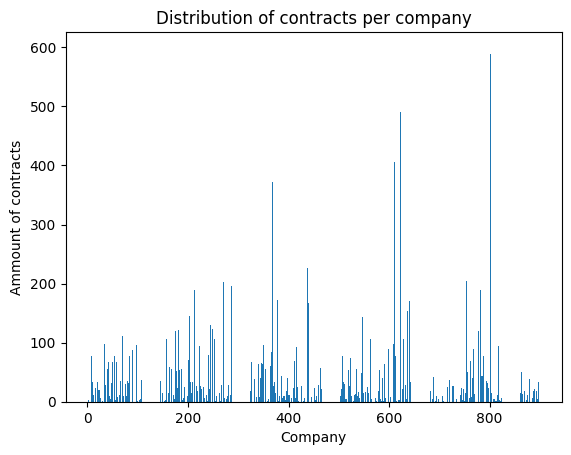

In [4]:
df1 = train.groupby('contractor_id').size()
df = df1.to_numpy()
plt.title("Distribution of сontracts per company")
plt.xlabel('Company')
plt.ylabel('Ammount of contracts')
plt.bar(df1.keys(), df)

In [5]:
df2 = train.isna().sum().sort_values(ascending=False)
df2

agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME              25425
agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME    23736
agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME    23736
agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME    21507
agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME    21507
                                                                                   ...  
counteragent_mean_agg_payments__g_contract__sum__all__sum__ALL_TIME                    0
counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME                     0
specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME                   0
agg_payments__g_contract__date__advance__min__ALL_TIME                                 0
default6                                                                               0
Length: 170, dtype: i

Количество NaN у каждой фичи

<BarContainer object of 170 artists>

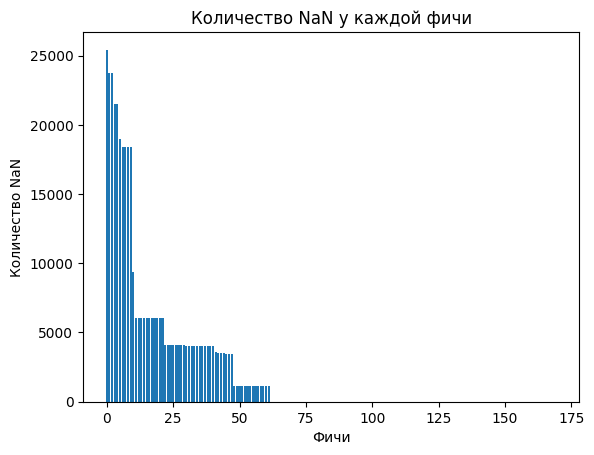

In [6]:
df3 = df2.to_numpy()
plt.title("Количество NaN у каждой фичи")
plt.xlabel('Фичи')
plt.ylabel('Количество NaN')
plt.bar(range(df3.shape[0]), df3)

Значение столбца `default6` не, меняющееся у строк с одинаковым `contract_id`(Этот анализ данных помог нам написать алгоритм, для улучшения решения. Выдвинем гипотезу, что если контракт плохой и его никто не выполняет, то
соотвественно, вероятность его выполнения у любого подрядчика будет довольно низка.
Проверим это следующим способом. Для каждого контракта будем брать рандомного подрядчика
и подставлять ему заместо признаков, связанных с контрактом, признаки контракта, который хотим проверить.
Если подрядчик не сможет выполнить эту работу, то скорее всего контракт действительно плохой.
Далее сблендим предсказания в отношении 2:1.
Данный алгоритм улучшает предсказания нашей основной модели. Мы группируем train датасет по contract_id и
берем среднее у каждого подрядчика. Далее мы проходимся по каждой строчке из теста и находим его ближайшего
соседа по графу расстояний между подрядчиками. Далее мы пользуемся проведенным нами анализом данным(у одного
контракт айди практически никогда не изменяется вероятность дефолта) и делаем новую строчку, в которой контракт
фичи от нынешнего контракта, а контрактор фичи от самого близкого подрядчика. В итоге мы предсказываем вероятность
дефолта для новой строчки и записываем в финальные предсказания среднее между вероятностями старой и новой строчки.
)

<BarContainer object of 2 artists>

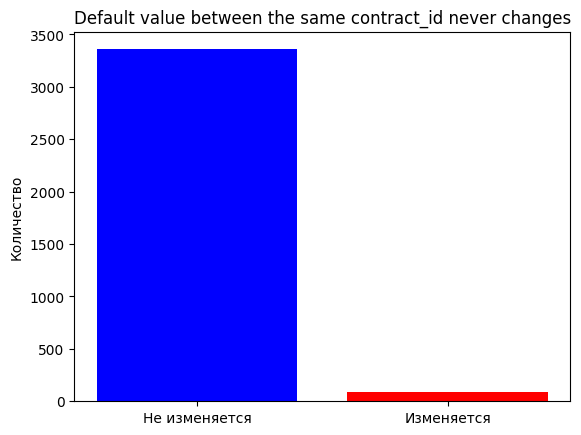

In [7]:
id = "contract_id"
tt = train.groupby(id)['default6'].mean() == 1.0
t = tt.sum()
tt2 = train.groupby(id)['default6'].mean() == 0.0
t2 = tt2.sum()
plt.title(f"Default value between the same {id} never changes")
plt.ylabel('Количество')
plt.bar(['Не изменяется', 'Изменяется'], [t + t2, 3448 - t - t2], color=['blue', 'red'])

Уникальные компании test и train и их пересечение (Мы проводили этот анализ данных для того чтобы понять, стоит ли писать временные ряды или нет. Как показывает график пресечение подрядчиков из трейна и теста достаточно большое, следовательно временные ряды будут полезными)

<BarContainer object of 3 artists>

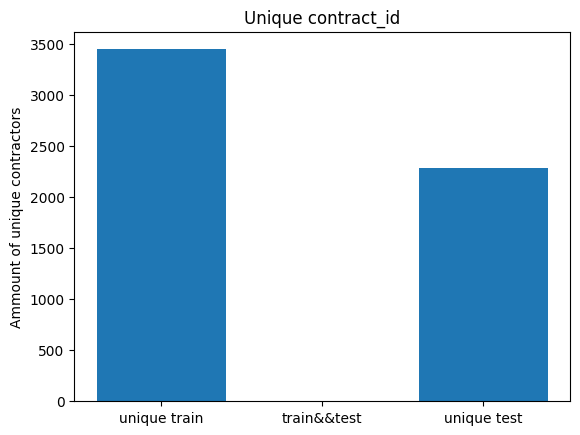

In [8]:
id = "contract_id"
tr = train[id].nunique()
tst = test[id].nunique()
intersect = np.intersect1d(train[id].unique(), test[id].unique()).shape[0]
plt.title(f"Unique {id}")
plt.ylabel('Ammount of unique contractors')
plt.bar(['unique train', "train&&test", 'unique test'], (tr, intersect, tst))

Корреляция между всеми фичами

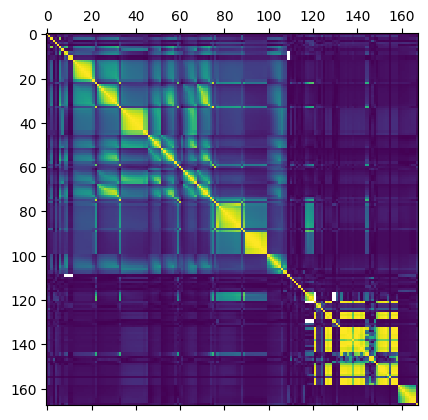

In [9]:
correlation = train.drop(columns=['contract_date', 'report_date']).corr().abs()
plt.matshow(correlation)

Корреляция всех фичей с default6

<BarContainer object of 168 artists>

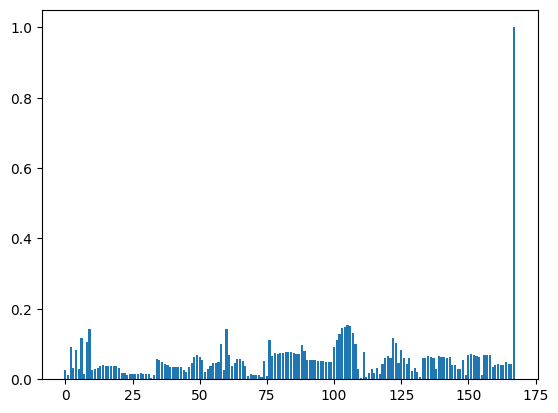

In [10]:
correlation = train.drop(columns=['contract_date', 'report_date']).corr()['default6'].abs()
plt.bar(range(correlation.shape[0]), correlation)

Топ 10 фичей по такой корреляции

In [11]:
correlation = train.drop(columns=['contract_date', 'report_date']).corr()['default6'].abs().sort_values(ascending=False)
correlation.head(10)

default6                                                                          1.00
agg_materials__g_contract__order_id__countDistinct__ALL_TIME                      0.15
agg_materials__g_contract__order_dt__min__ALL_TIME                                0.15
agg_materials__g_contract__order_id__countDistinct__12W                           0.15
agg_materials__g_contract__order_id__countDistinct__8W                            0.14
agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME   0.14
specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME              0.14
agg_materials__g_contract__material_type_id__countDistinct__ALL_TIME              0.13
agg_materials__g_contract__order_id__countDistinct__4W                            0.13
agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME           0.12
Name: default6, dtype: float64

Анализ графа расстояний

In [12]:
# Количество ребер в графе
graph.shape[0]

327186

In [13]:
# Количество уникальных вешин в нем
graph['contractor_id'].nunique(), graph['contractor_id2'].nunique()

(803, 803)

KMeans класстеризация графа

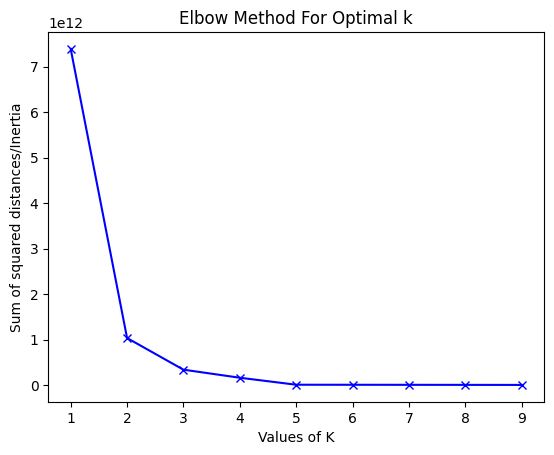

In [14]:
#Найдем количество класстеров в графе с помощью алгоритма kmeans методом локтя
d_id = graph.groupby('contractor_id')[["contractor_id2", "Distance"]]
distances_graph = list(list(653 for i in range(899)) for j in range(899))
for name, group in d_id:
    g = group.sort_values(by="contractor_id2")
    distances_graph[name][name] = 0
    for i in g.values:
        if name != i[0]:
            distances_graph[name][i[0]] = float(i[1])
            distances_graph[i[0]][name] = float(i[1])

dst_df = pd.DataFrame(columns=["contractor_id"] + [f'contractor_{i}' for i in range(899)])
for i in range(899):
    dst_df.loc[len(dst_df), dst_df.columns] = [i] + distances_graph[i]
dst_df = dst_df.map(float)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 10)
for num_clusters in K:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dst_df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

1. Построю граф на основе данных.
2. Вычислю меры центральности, такие как:
    Степень узлов.
    Близость (closeness).
    Центральность по междуузлиям (betweenness).
    Далее я построю визуализацию графа, где узлы с наибольшей центральностью будут выделены.

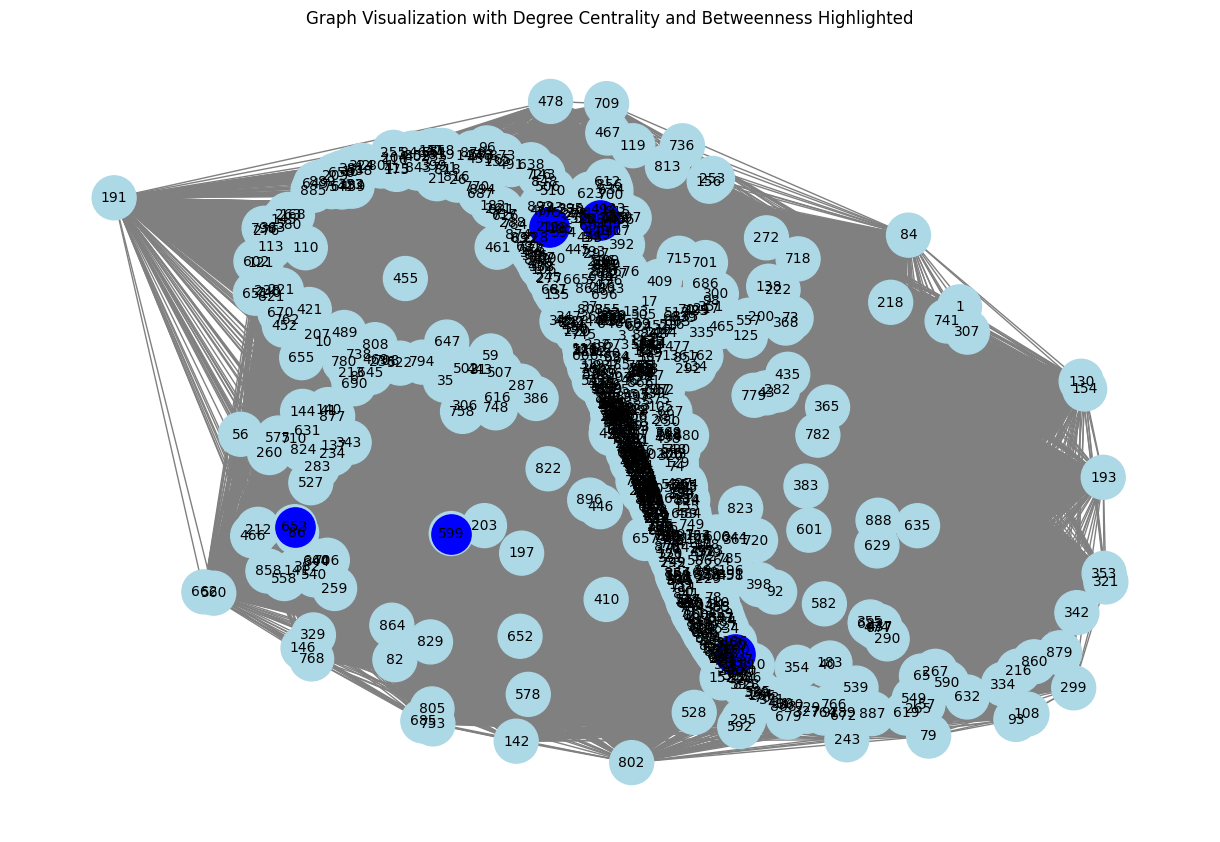

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the data
G = nx.Graph()

# Add edges with weights (distances)
for _, row in graph.iterrows():
    G.add_edge(row['contractor_id'], row['contractor_id2'], weight=row['Distance'])

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Visualize the graph, emphasizing nodes with high degree centrality
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout for visualization

# Node sizes based on degree centrality
node_sizes = [degree_centrality[node] * 1000 for node in G.nodes()]

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', font_size=10, edge_color='gray')

# Highlight nodes with highest betweenness centrality
top_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:5]
nx.draw_networkx_nodes(G, pos, nodelist=top_betweenness, node_color='blue', node_size=800)

plt.title('Graph Visualization with Degree Centrality and Betweenness Highlighted')
plt.show()


синие - самые важные узлы

Преобразование графа с помощью алгортима Флойда для поиска кратчайших расстояний между подрядчиками

In [16]:
#Данное преобразовнание было выполено для того, чтобы из данного графа сделать полный, для этого мы искали минимальное расстояние между парой вершин и записывали его в новый файл csv.
import numpy as np

vertices = set(graph['contractor_id']).union(set(graph['contractor_id2']))
vertices = sorted(list(vertices))
n = len(vertices)
inf = float('inf')
dist_matrix = np.full((n, n), inf)

np.fill_diagonal(dist_matrix, 0)

vertex_index = {v: i for i, v in enumerate(vertices)}

for _, row in graph.iterrows():
    u_idx = vertex_index[row['contractor_id']]
    v_idx = vertex_index[row['contractor_id2']]
    dist_matrix[u_idx, v_idx] = row['Distance']
    dist_matrix[v_idx, u_idx] = row['Distance']

for k in range(n):
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = min(dist_matrix[i, j], dist_matrix[i, k] + dist_matrix[k, j])
left = []
right = []
dist = []
for i in range(n):
    for j in range(n):
        if i != j:
            left.append(vertices[i])
            right.append(vertices[j])
            dist.append(dist_matrix[i, j])
short = pd.DataFrame({'contractor_id1': left, 'contractor_id2': right, 'Distance': dist})
short.to_csv('subms/shortest_paths.csv')

In [17]:
#Количество компонент связности в графе
G_undirected = G.to_undirected()

# Use NetworkX to find connected components
connected_components = list(nx.connected_components(G_undirected))

# Display the number of connected components and a few of them
num_connected_components = len(connected_components)
sample_connected_components = connected_components[:5]  # Show first 5 components

num_connected_components, sample_connected_components
#num_connected_components == 1, следовательно граф связный

(1,
 [{0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   26,
   27,
   29,
   30,
   31,
   32,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   61,
   62,
   63,
   64,
   65,
   67,
   68,
   70,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   86,
   88,
   89,
   90,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
   138,
   139,
   140,
   141,
   142,
   143,
   144,
   145,
   146,
   147,
   149,
   150,
   151,
   1

Класстеризация и превращение в ембединнг данных из трейна, показывает, что в нем практически нет выбросов и6 несмотря на его несбаласированность данные размещены достаточно равномерно

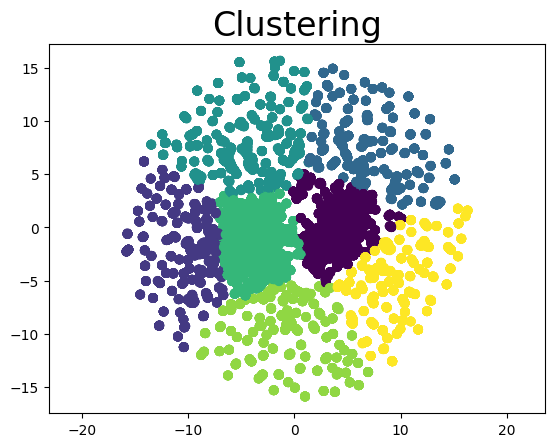

In [19]:
import seaborn as sns

train2 = train.drop(
    columns=['contract_date', 'report_date']).fillna(
    0)
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()
scaled_penguin_data = StandardScaler().fit_transform(train2)
embedding = reducer.fit_transform(scaled_penguin_data)


def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)


clust_labels, centroids = doKmeans(embedding, 7)
kmeans = pd.DataFrame(clust_labels)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[kmeans[0]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('Clustering', fontsize=24);

Класстеризация и превращение в ембединнги данных теста показывает, что он является подвыборкой трэйна, поэтому кроссвалидация на трейне будет давать результат схожий с лидербордом

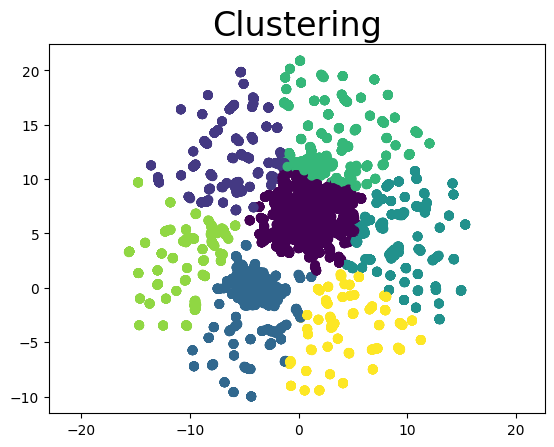

In [20]:
test2 = test.drop(columns=['contract_date', 'report_date']).fillna(0)
reducer = umap.UMAP()
scaled_penguin_data = StandardScaler().fit_transform(test2)
embedding = reducer.fit_transform(scaled_penguin_data)
clust_labels, centroids = doKmeans(embedding, 7)
kmeans = pd.DataFrame(clust_labels)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[kmeans[0]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('Clustering', fontsize=24);

График дефолта первых двадцати компаний показывает, что если у компании случился дефолт, то это не значит, что она не сможет выйти из него

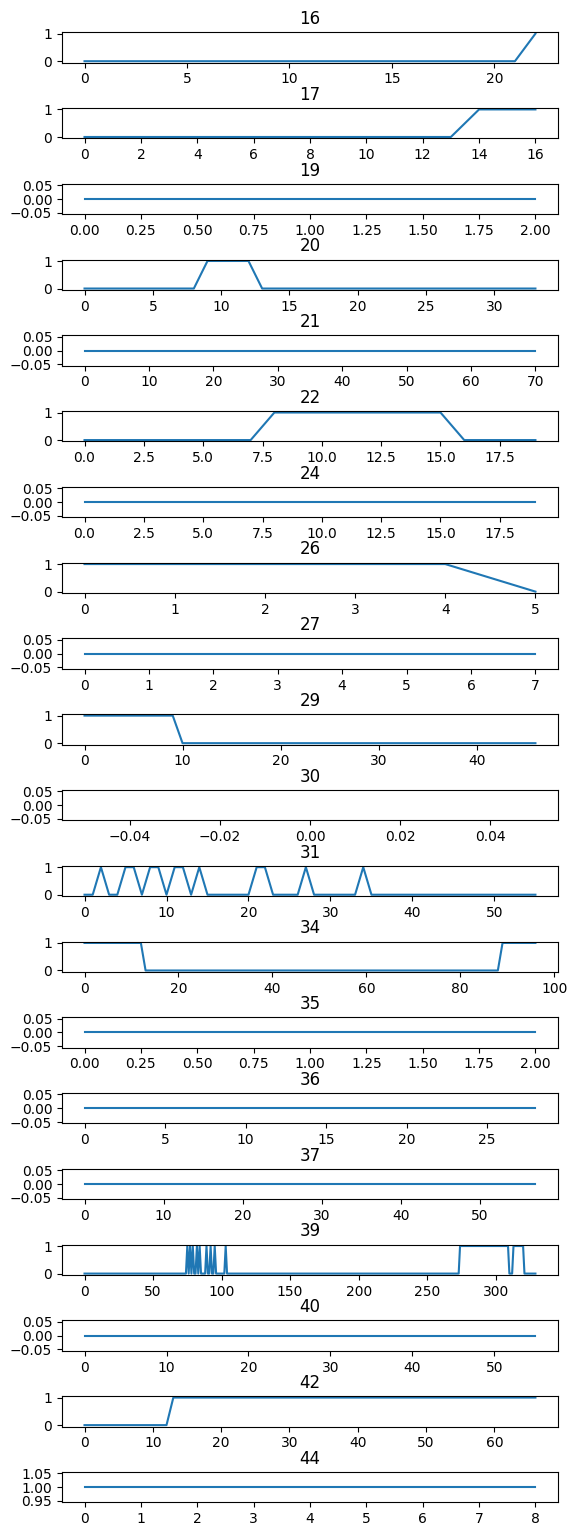

In [21]:
feature = 'default6'
df = train.sort_values(by='contract_date').groupby('contractor_id')[feature]
count = 0
f, axis = plt.subplots(20)
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=1.5, wspace=0.4)
f.set_figheight(15)
for name, group in df:
    if count >= 10:
        axis[count - 10].plot(group.values)
        axis[count - 10].set_title(name)
    count += 1

    if count >= 30:
        break
plt.show()

Остальной анализ данных находитится в файле **train.ipynb**(feature importance from catboost, lgb, xgb, randomforest, shap values, lazypredict, timeseries, graph features и т д)

Проверка гипотиз (не используются в финальном коде, так как выдают худший скор)
1. Стемминг с использованием множества других моделей
2. Ансамбли
3. Использование других моделей
4. Генерация полиминальных фичей
5. Временных рядов по проектам, специализации и зданиям
5. Добавление как фичи:
    1. двух ближайших контрактов по времени той же компании к каждому контракту
    2. среднего default6 по `contract_id`, `building_id`
    3. среднего всех фичей по `contract_id`
    4. номера к-минс класстера для каждого контракта
    5. количества контрактов у компании
    6. среднее время между контрактами компании

**Стемминг**

In [22]:
import xgboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import svm
import catboost
from sklearn.neighbors import KNeighborsClassifier

X = X.fillna(0).drop(columns=['contract_date', 'report_date'])
y = y['default6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)
cb_model = CatBoostClassifier(use_best_model=True)
cb_model.fit(X_train, y_train, verbose=100, eval_set=(X_test, y_test))
pp2 = cb_model.predict_proba(X_test)[:, 1]

t = cb_model.get_feature_importance(prettified=True)
dt = KNeighborsClassifier()
dt2 = xgboost.XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
dt3 = GradientBoostingClassifier()
dt4 = SVC()
dt5 = RandomForestClassifier()
dt6 = DecisionTreeClassifier()
dt7 = catboost.CatBoostClassifier(verbose=False)

dt88 = KNeighborsClassifier()
dt8 = xgboost.XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
dt9 = GradientBoostingClassifier()
dt10 = SVC()
dt11 = RandomForestClassifier()
dt12 = DecisionTreeClassifier()
dt13 = catboost.CatBoostClassifier(verbose=False)
X_train1 = X[0:len(X) // 2]
X_train2 = X[len(X) // 2::]
y_train1 = y[0:len(y) // 2]
y_train2 = y[len(y) // 2::]
dt.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt2.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt3.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt4.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt5.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt6.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)
dt7.fit(X_train1[list(t[t.Importances > 0.01]['Feature Id'])], y_train1)

dt88.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt8.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt9.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt10.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt11.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt12.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)
dt13.fit(X_train2[list(t[t.Importances > 0.01]['Feature Id'])], y_train2)

train2_ = X_train2.copy()
train1_ = X_train1.copy()
test = test.fillna(0).drop(columns=['contract_date', 'report_date'])
temp = test.copy()
test_ = test.copy()
train2_['f41'] = dt.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f41'] = (dt.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt88.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2
train2_['f42'] = dt2.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f42'] = (dt2.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt8.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2
train2_['f43'] = dt3.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f43'] = (dt3.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt9.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2
train2_['f44'] = dt4.predict(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])
print(1)
test_['f44'] = (dt4.predict(temp[list(t[t.Importances > 0.01]['Feature Id'])]) + dt10.predict(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])) / 2
train2_['f45'] = dt5.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f45'] = (dt5.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt11.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2
train2_['f46'] = dt6.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f46'] = (dt6.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt12.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2
train2_['f47'] = dt7.predict_proba(X_train2[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
print(1)
test_['f47'] = (dt7.predict_proba(temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1] + dt13.predict_proba(
    temp[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]) / 2

train1_['f41'] = dt88.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train1_['f42'] = dt8.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train1_['f43'] = dt9.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train1_['f44'] = dt10.predict(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])
train1_['f45'] = dt11.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train1_['f46'] = dt12.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train1_['f47'] = dt13.predict_proba(X_train1[list(t[t.Importances > 0.01]['Feature Id'])])[:, 1]
train2 = train2_.copy()
train1 = train1_.copy()
temp = test_.copy()
train = pd.concat([train1, train2])
X = train
X

Learning rate set to 0.070825
0:	learn: 0.6512279	test: 0.6513223	best: 0.6513223 (0)	total: 70.9ms	remaining: 1m 10s
100:	learn: 0.2475160	test: 0.2615656	best: 0.2615656 (100)	total: 1.66s	remaining: 14.8s
200:	learn: 0.1639273	test: 0.1793885	best: 0.1793885 (200)	total: 3.14s	remaining: 12.5s
300:	learn: 0.1152055	test: 0.1334837	best: 0.1334837 (300)	total: 4.62s	remaining: 10.7s
400:	learn: 0.0848929	test: 0.1031963	best: 0.1031963 (400)	total: 6.12s	remaining: 9.14s
500:	learn: 0.0659056	test: 0.0838497	best: 0.0838497 (500)	total: 7.67s	remaining: 7.64s
600:	learn: 0.0524751	test: 0.0699233	best: 0.0699233 (600)	total: 9.11s	remaining: 6.05s
700:	learn: 0.0428361	test: 0.0603703	best: 0.0603703 (700)	total: 10.7s	remaining: 4.58s
800:	learn: 0.0359799	test: 0.0539497	best: 0.0539497 (800)	total: 12.5s	remaining: 3.1s
900:	learn: 0.0305954	test: 0.0493344	best: 0.0493344 (900)	total: 14.1s	remaining: 1.55s
999:	learn: 0.0262826	test: 0.0450930	best: 0.0450930 (999)	total: 16s	re

,contract_id,specialization_id,contract_init_sum,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,f41,f42,f43,f44,f45,f46,f47
0,5433,18,1.12,43,701,438,0.79,-0.54,0.00,0.00,...,-0.23,-0.26,-0.26,1.00,0.91,0.87,0,0.71,1.00,0.85
1,6875,18,1.61,31,268,438,2.68,0.74,1.67,1.73,...,-0.23,-0.26,-0.26,0.00,0.99,0.86,0,0.72,1.00,0.91
2,1476,18,-0.36,31,268,438,-0.42,-0.54,0.00,0.00,...,-0.23,-0.26,-0.26,0.80,0.22,0.56,0,0.44,0.00,0.51
3,4469,12,-0.09,43,697,484,-0.19,-0.54,0.00,0.00,...,-0.23,-0.26,-0.26,0.00,0.01,0.23,0,0.20,0.00,0.17
4,1330,12,-0.52,49,224,484,0.13,0.74,0.55,0.55,...,-0.23,-0.26,-0.26,0.00,0.00,0.13,0,0.14,0.00,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,5078,21,-0.48,18,915,683,-0.50,0.74,-0.38,-0.42,...,0.18,0.15,0.15,0.00,0.00,0.06,0,0.16,0.00,0.01
28827,3854,21,-0.50,18,915,683,-0.52,0.74,-0.39,-0.43,...,0.18,0.15,0.15,0.00,0.00,0.04,0,0.16,0.00,0.01
28828,5351,21,-0.48,50,298,683,-0.52,-0.54,0.00,0.00,...,0.18,0.15,0.15,0.00,0.00,0.14,0,0.21,0.00,0.03
28829,57,21,-0.47,45,915,683,-0.50,-0.54,0.00,0.00,...,0.18,0.15,0.15,0.00,0.00,0.10,0,0.14,0.00,0.03


Скор на лидерборде 0.551-0.557(1 этап AIIJC)

Ensemble

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=100).fit(X, y)

В итоге мы пришли к выводу, что следует использовать только 2 модели, это RandomForestClassifier и CatBoostClassifier, так как они выдают лучший скор и наиболее сильно подходять к этому датасету. Мы это выяснили в результате помощью собственных исследований, наблюдений и инструмента **lazypredict**, который перебирает все модели и сравнивает их

Добавление **временных рядов** не улучшило результат, так как слишком мало данных было для их обучения(10 строк в среднем на компанию)

Мы отказались от добавления **полимиальных фичей**, потому что их получалось слишком много(20k+), наши модели по определению feature importance с ними не справлялись, и также давали низкий скор на валидации и лидерборде

**Добавление как фичи:**
    1. двух ближайших контрактов по времени той же компании к каждому контракту - слишком много похожих фичей и есть те контакты, у которых нет соседних
    2. среднего default6 по `contract_id`, `building_id` - понижало скор, так как модель слишком сильно опиралась на эти значения при обучении и в тесте провалилась
    3. среднего всех фичей по `contract_id` - слишком много похожих фичей и есть те контакты, у которых нет соседних
    4. номера к-минс класстера для каждого контракта - понижало скор, так как из диаграм приведенных выше понятно, что у данного датасета класстеры очень сильно размыты и соединены
    5. количества контрактов у компании - не изменило скор
    6. среднее время между контрактами компании - не изменило скор

**Самые сильные фичи, которые мы сделали(проверка уже рабочих гипотиз)**
1)+0.11 score  (средняя сумма за 3 месяца по contract_id)(1 этап AIIJC)

In [25]:
X = pd.read_csv('data/train_X.csv')
y = pd.read_csv('data/train_y.csv')
test = pd.read_csv('data/test2_X.csv')
train = X.merge(y, on=['contract_id', 'report_date'])

In [26]:
test['contract_current_sum_mean_3M'] = test.groupby('contract_id')['contract_current_sum'].rolling(window=3,
                                                                                                   min_periods=1).mean().reset_index(
    0, drop=True)
train['contract_current_sum_mean_3M'] = train.groupby('contract_id')['contract_current_sum'].rolling(window=3,
                                                                                                     min_periods=1).mean().reset_index(
    0, drop=True)  # средняя сумма за 3 месяца по contract_id

Данная фича выдает хороший скор при обучении модели на ней, так как имеет одну из самых больших корреляций с default6 столбцом и feature importance. Еще один график по корреляции('contract_current_sum_mean_3M' находится слева):

<BarContainer object of 169 artists>

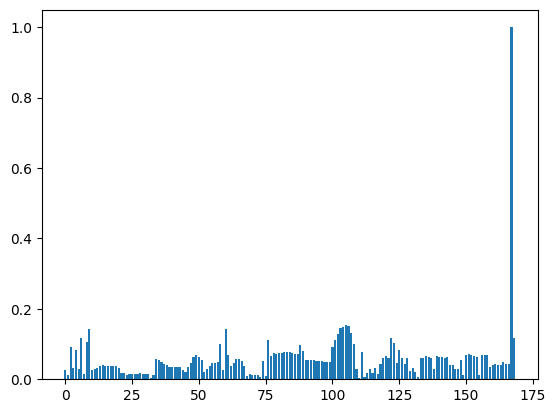

In [27]:
d_f = train.drop(columns=['contract_date', 'report_date']).corrwith(train['default6']).abs().to_numpy()
plt.bar(range(d_f.shape[0]), d_f)

2) Фичи, опирающиеся на логику, финансовую грамотность и подтвержденные программой:
+0.04(1 этап AIIJC)

In [28]:
#В данных фичах хранится 1 или 0 в зависимости от значения true или false. Они заключаются в том, что показывают больше ли доходы чем расходы и больше ли доходы чем расходы+налоги, ведь известно, что дефолт возникает в основном из-за задолженности и невозможности выпалчивать ее вовремя, поэтому когда компания больше тратит чем зарабатывает, то она больше подвержена дефолту, что и показывают данные фичи
train['Income > Expenses'] = train['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] > train[
    'agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME']  # доходы > расходы?
train['Income > Expenses'] = train['Income > Expenses'].map(int)
train['Income > Taxes + Expenses'] = train['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] > (
            train['agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME'] + train[
        'agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME'])  # доходы > расходы + налоги?
train['Income > Taxes + Expenses'] = train['Income > Taxes + Expenses'].map(int)
test['Income > Expenses'] = test['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] > test[
    'agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME']
test['Income > Expenses'] = test['Income > Expenses'].map(int)
test['Income > Taxes + Expenses'] = test['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] > (
            test['agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME'] + test[
        'agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME'])
test['Income > Taxes + Expenses'] = test['Income > Taxes + Expenses'].map(int)

In [29]:
#удаление фичей, в которых присутствует слишком много NaN
to_drop, features = [], []
for i in train.isnull().sum().items():
    if i[-1] > len(train) * 0.7:        
        to_drop.append(i[0])
    if 0 < i[-1] <= len(train) * 0.7:       
        features.append(i[0])
to_drop

['agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME']

Использованные модели и методы в полуфинале AIIJC:

Временные ряды + стемминг, которые используются в финальном решении

In [30]:
#Для обучения времменных рядов по данным каждого подрядчика используется в общей сумме примерно 500 моделей
"""В нашем решении мы использовали временные ряды и стемминг
Шаги реализации:
1. Делаем стемминг на всех данных для получения предсказаний, которые отображают вероятность дефолта определенной записи
у подрядчика, не делая глубокий анализ по нему, как бы отражая вероятность дефолта вообщем для таких данных. Значения,
полученные со стемминга помогают модели временного ряда давать более точные предсказания, так как без стемминга модель бы
давала менее точные предикты в связи с небольшим количеством записей у каждого подрядчика. Модели временного ряда являются
узконаправленными. В качестве моделей для стемминга мы использовали RandomForestClassifier и CatBoostClassifier, так как они
лучше всего подходят для данного набора данных(В этом ноутбуке есть доказательство этого с помощью библиотеки LazyPredict).
Записываем вероятности, полученные со стемминга в коллонку 'score_from_cross_val'.
2. Группируем по train датасет contractor_id
3. Обучаем свою модель для каждой группы строк, в которой одинаковый contractor_id, имеющий больше 20 записей в
трейне(Значение в 20 записей было выбрано для того чтобы избежать неточных результатов от моделей, обученных на менее чем 20 записей)
4. Для того чтобы получить предсказания с теста, мы записываем предикты основной модели и колонку 'score_from_cross_val' и предсказываем вероятности дефолта на тестовых данных
5. Записываем полученные предикты группы моделей с весом 0,33 и предикты от основной модели с весом 0.67"""
total = train.columns
class TimeSeries:
    def __init__(self):
        """A class for a Time Series Stemming model that will make model-based predictions,
        which were trained on data over different periods of time. The class implements the following methods:
        fit, predict_proba, submit, init_models, time_series_predict.
        """
        self.rf_model1 = RandomForestClassifier(5000, n_jobs=-1)
        self.rf_model2 = RandomForestClassifier(5000, n_jobs=-1)
        self.cb_model1 = CatBoostClassifier(2000, verbose=False)
        self.cb_model2 = CatBoostClassifier(2000, verbose=False)

    def fit(self, X, y):
        """Fit Classification algorithms to X_train and y_train.
        Parameters
        ----------
        X : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        """
        self.X = X.copy()
        self.y = y.map(int)
        
        self.X1, self.X2, self.y1, self.y2 = train_test_split(self.X, self.y, test_size=0.5, shuffle=False)

        self.rf_model1.fit(self.X1, self.y1)
        self.rf_model2.fit(self.X2, self.y2)

        self.cb_model1.fit(self.X1, self.y1)
        self.cb_model2.fit(self.X2, self.y2)

    def predict_proba(self):
        """Prediction probability algorithms to data."""
        self.p1 = self.rf_model2.predict_proba(self.X1)[:, 1]
        self.p2 = self.cb_model2.predict_proba(self.X1)[:, 1]
        self.preds1 = self.p1 * 0.8 + self.p2 * 0.2

        self.X1['score_from_cross_val'] = self.preds1

        self.p3 = self.rf_model1.predict_proba(self.X2)[:, 1]
        self.p4 = self.cb_model1.predict_proba(self.X2)[:, 1]
        self.preds2 = self.p3 * 0.8 + self.p4 * 0.2

        self.X2['score_from_cross_val'] = self.preds2

        return pd.concat([self.X1, self.X2])

    def submit(self, X):
        """Prediction probability algorithms to data.
        Parameters
        ----------
        X : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, shuffle=False)

        p1 = self.rf_model2.predict_proba(X1)[:, 1]
        p2 = self.cb_model2.predict_proba(X1)[:, 1]
        preds1 = p1 * 0.8 + p2 * 0.2

        X1['score_from_cross_val'] = preds1

        p3 = self.rf_model1.predict_proba(X2)[:, 1]
        p4 = self.cb_model1.predict_proba(X2)[:, 1]
        preds2 = p3 * 0.8 + p4 * 0.2

        X2['score_from_cross_val'] = preds2

        return pd.concat([X1, X2])

    def init_models(self, data):
        """Fit Classification algorithms to data.
        Parameters
        ----------
        data : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        total3 = total + ['contractor_id', 'score_from_cross_val', 'score']
        for_each = data[total3].groupby('contractor_id')
        self.models = {}
        for name, group in tqdm(for_each):
            if group.shape[0] > 20:
                mod = CatBoostClassifier(allow_const_label=True, verbose=False)
                mod.fit(group.drop(columns=['score']), group['score'])
                self.models[name] = mod
        print("DONE")

    def time_series_predict(self, data):
        """Prediction probability algorithms to data.
        Parameters
        ----------
        X : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        tt = data.groupby('contractor_id')
        fn = pd.DataFrame(columns=["c", 'score2'])
        count = 0
        total_ts = total + ['contractor_id', 'score_from_cross_val']
        for name, group in tqdm(tt):
            if name in self.models:
                ids = group['c']
                predd = self.models[name].predict_proba(group[total_ts])[:, 1]
                mem = pd.DataFrame({"c": ids, 'score2': predd})
                fn = pd.concat([fn, mem])
                count += 1

        submit2 = data.merge(fn, on='c', how="left")
        submit2['score'][submit2['score2'].notnull()] = (2 * submit2['score'] + submit2['score2']) / 3
        # print(submit2.score2)
        return (submit2.drop(columns=['score2', 'c']), submit2)

    def save_model(self, path: str):
        """Model save algorithms.
        Parameters
        ----------
        path : str,
            String with path you need to save model.
        """
        joblib.dump(self, path)

Преобразование графа с помощью алгортима Флойда для поиска кратчайших расстояний между подрядчиками

In [31]:
#Данное преобразовнание было выполено для того, чтобы из данного графа сделать полный, для этого мы искали минимальное расстояние между парой вершин и записывали его в новый файл csv.
import numpy as np

vertices = set(graph['contractor_id']).union(set(graph['contractor_id2']))
vertices = sorted(list(vertices)) 
n = len(vertices)
inf = float('inf')
dist_matrix = np.full((n, n), inf)

np.fill_diagonal(dist_matrix, 0)

vertex_index = {v: i for i, v in enumerate(vertices)}

for _, row in graph.iterrows():
    u_idx = vertex_index[row['contractor_id']]
    v_idx = vertex_index[row['contractor_id2']]
    dist_matrix[u_idx, v_idx] = row['Distance']
    dist_matrix[v_idx, u_idx] = row['Distance'] 


for k in range(n):
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = min(dist_matrix[i, j], dist_matrix[i, k] + dist_matrix[k, j])

In [32]:
left = []
right = []
dist = []
for i in range(n):
    for j in range(n):
        if i!=j:
            left.append(vertices[i])
            right.append(vertices[j])
            dist.append(dist_matrix[i, j])

In [33]:
short = pd.DataFrame({'contractor_id1': left, 'contractor_id2': right, 'Distance': dist})
short.to_csv('shortest_paths.csv')

Нахождение компонент сильной связности в графе

In [34]:
#Данный код выдает номер компоненты сильной связности для каждого из подрядчиков
#Подрядчики в одной компоненте сильной связности имеют схожие интересы, или находятся в одной сфере работы, или имеют одного владельца
import networkx as nx

edges = graph[['contractor_id', 'contractor_id2']].values

# Create a directed graph using NetworkX
G = nx.DiGraph()
G.add_edges_from(edges)
strongly_connected_components = list(nx.strongly_connected_components(G))
num_scc = len(strongly_connected_components)
sample_scc = strongly_connected_components[:5] 

num_scc, sample_scc


(62,
 [{151, 172, 245, 288, 422, 445, 514, 674, 710, 810, 849, 877},
  {8, 12, 26, 47, 104, 122, 192, 221, 240, 248, 324, 352, 406, 516, 754},
  {76, 183, 323, 331, 348, 353, 399, 513, 553, 621, 672, 848},
  {16, 70, 217, 330, 369, 403, 540, 581, 803, 821},
  {5,
   63,
   142,
   160,
   173,
   201,
   410,
   432,
   438,
   468,
   542,
   583,
   668,
   694,
   740,
   816,
   836}])

In [35]:

# Convert the result to a DataFrame and save it to CSV
output_df = pd.DataFrame(dist_matrix, index=vertices, columns=vertices)
output_file_path = 'shortest_paths.csv'
output_df.to_csv(output_file_path)

output_file_path  # Returning the path to the generated CSV


'shortest_paths.csv'

Объяснение почему блендинг моделей, обученных на разных выборках фичей из трэин датасета работает и улучшает скор

<Axes: >

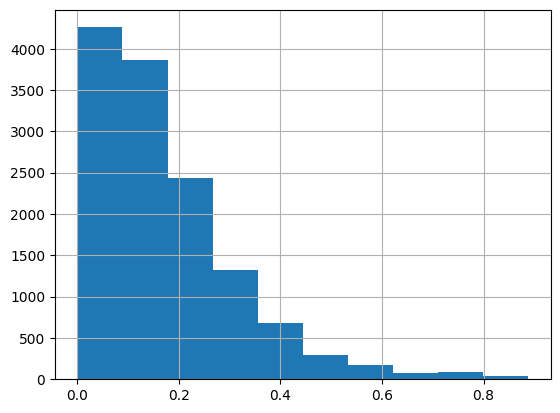

In [36]:
#Давайте рассмотрим распределения скора сабмтов, полученных с помощью моделей, обученных на разных фичах
import pandas as pd
subm553 = pd.read_csv('subms/subm553.csv')
subm551 = pd.read_csv('subms/subm551.csv')
subm551.score.hist()

<Axes: >

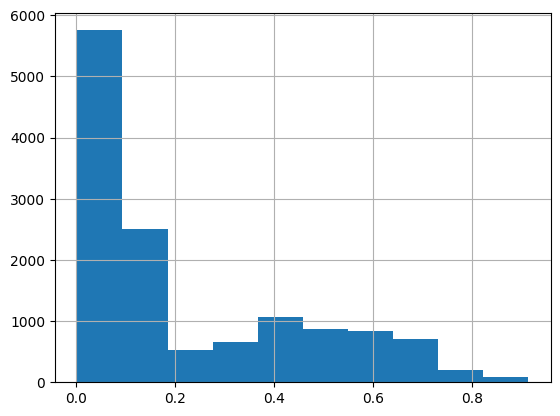

In [37]:
subm553.score.hist()

<Axes: >

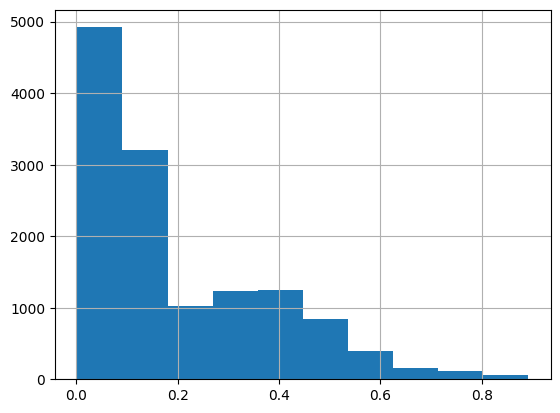

In [38]:
# Как вы можете увидеть, данные сабмиты имеют разное распределение скора, в тоже время имея достаточно высокий и схожий скор, следовательно если совместить эти две модели, то финальный скор будет выше, что подтверждает наш результат на лидерборде
((subm553.score+subm551.score)/2).hist()

Проверка гипотиз на полуфиналe AIIJC, которые не зашли в финальное решение

In [39]:
#Проверка гипотизы класстеризации за счет разбиения графа расстояний между подрядчиками на компоненты связности
#Данная гипотеза не увенчалась успехом, так как данный граф связный, то есть имеет только одну компоненту связности
G_undirected = G.to_undirected()

# Use NetworkX to find connected components
connected_components = list(nx.connected_components(G_undirected))

# Display the number of connected components and a few of them
num_connected_components = len(connected_components)
sample_connected_components = connected_components[:5]  # Show first 5 components

num_connected_components, sample_connected_components


(1,
 [{0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   26,
   27,
   29,
   30,
   31,
   32,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   61,
   62,
   63,
   64,
   65,
   67,
   68,
   70,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   86,
   88,
   89,
   90,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
   138,
   139,
   140,
   141,
   142,
   143,
   144,
   145,
   146,
   147,
   149,
   150,
   151,
   1

Обучение временных рядов не только на contractor_id, но и на project_id

In [40]:
#Данная гипотиза была опровергнута, так как submit, сделанный из ее предсказаний выдал плохой скор на лидерборде
#Также, последующий анализ данных показал, что project_id не находится не в каких фичах, использовавшихся для обучения наших моделей, следовательно финальные предикты слабо зависят от него и поэтому временные ряды по нему давали такой плохой скор на лидерборже
total = train.columns
class TimeSeries_for_project_id:
    def __init__(self):
        """A class for a Time Series Stemming model that will make model-based predictions,
        which were trained on data over different periods of time. The class implements the following methods:
        fit, predict_proba, submit, init_models, time_series_predict.
        """
        self.rf_model1 = RandomForestClassifier(5000, n_jobs=-1)
        self.rf_model2 = RandomForestClassifier(5000, n_jobs=-1)
        self.cb_model1 = CatBoostClassifier(2000, verbose=False)
        self.cb_model2 = CatBoostClassifier(2000, verbose=False)

    def fit(self, X, y):
        """Fit Classification algorithms to X_train and y_train.
        Parameters
        ----------
        X : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        """
        self.X = X.copy()
        self.y = y.map(int)
        
        self.X1, self.X2, self.y1, self.y2 = train_test_split(self.X, self.y, test_size=0.5, shuffle=False)

        self.rf_model1.fit(self.X1, self.y1)
        self.rf_model2.fit(self.X2, self.y2)

        self.cb_model1.fit(self.X1, self.y1)
        self.cb_model2.fit(self.X2, self.y2)

    def predict_proba(self):
        """Prediction probability algorithms to data."""
        self.p1 = self.rf_model2.predict_proba(self.X1)[:, 1]
        self.p2 = self.cb_model2.predict_proba(self.X1)[:, 1]
        self.preds1 = self.p1 * 0.8 + self.p2 * 0.2

        self.X1['score_from_cross_val'] = self.preds1

        self.p3 = self.rf_model1.predict_proba(self.X2)[:, 1]
        self.p4 = self.cb_model1.predict_proba(self.X2)[:, 1]
        self.preds2 = self.p3 * 0.8 + self.p4 * 0.2

        self.X2['score_from_cross_val'] = self.preds2

        return pd.concat([self.X1, self.X2])

    def submit(self, X):
        """Prediction probability algorithms to data.
        Parameters
        ----------
        X : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, shuffle=False)

        p1 = self.rf_model2.predict_proba(X1)[:, 1]
        p2 = self.cb_model2.predict_proba(X1)[:, 1]
        preds1 = p1 * 0.8 + p2 * 0.2

        X1['score_from_cross_val'] = preds1

        p3 = self.rf_model1.predict_proba(X2)[:, 1]
        p4 = self.cb_model1.predict_proba(X2)[:, 1]
        preds2 = p3 * 0.8 + p4 * 0.2

        X2['score_from_cross_val'] = preds2

        return pd.concat([X1, X2])

    def init_models(self, data):
        """Fit Classification algorithms to data.
        Parameters
        ----------
        data : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        total3 = total + ['project_id', 'score_from_cross_val', 'score']
        for_each = data[total3].groupby('project_id')
        self.models = {}
        for name, group in tqdm(for_each):
            if group.shape[0] > 20:
                mod = CatBoostClassifier(allow_const_label=True, verbose=False)
                mod.fit(group.drop(columns=['score']), group['score'])
                self.models[name] = mod
        print("DONE")

    def time_series_predict(self, data):
        """Prediction probability algorithms to data.
        Parameters
        ----------
        X : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        """
        tt = data.groupby('project_id')
        fn = pd.DataFrame(columns=["c", 'score2'])
        count = 0
        total_ts = total + ['project_id', 'score_from_cross_val']
        for name, group in tqdm(tt):
            if name in self.models:
                ids = group['c']
                predd = self.models[name].predict_proba(group[total_ts])[:, 1]
                mem = pd.DataFrame({"c": ids, 'score2': predd})
                fn = pd.concat([fn, mem])
                count += 1

        submit2 = data.merge(fn, on='c', how="left")
        submit2['score'][submit2['score2'].notnull()] = (2 * submit2['score'] + submit2['score2']) / 3
        # print(submit2.score2)
        return (submit2.drop(columns=['score2', 'c']), submit2)

    def save_model(self, path: str):
        """Model save algorithms.
        Parameters
        ----------
        path : str,
            String with path you need to save model.
        """
        joblib.dump(self, path)

KMeans класстеризация графа

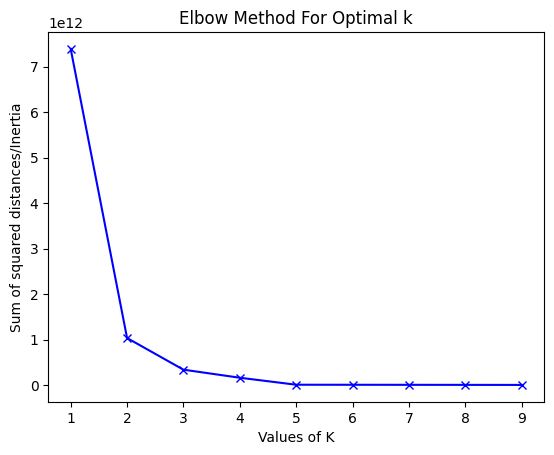

In [41]:
#Кминс класстеризация графа расстояний подрядчиков не дала много скора на лидерборда. Вместо нее для класстеризации использовался алгоритм для нахождения компонент сильно связности
d_id = graph.groupby('contractor_id')[["contractor_id2", "Distance"]]
distances_graph = list(list(653 for i in range(899)) for j in range(899))
for name, group in d_id:
    g = group.sort_values(by="contractor_id2")
    distances_graph[name][name] = 0
    for i in g.values:
        if name != i[0]:
            distances_graph[name][i[0]] = float(i[1])
            distances_graph[i[0]][name] = float(i[1])

dst_df = pd.DataFrame(columns=["contractor_id"] + [f'contractor_{i}' for i in range(899)])
for i in range(899):
    dst_df.loc[len(dst_df), dst_df.columns] = [i] + distances_graph[i]
dst_df = dst_df.map(float)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 10)
for num_clusters in K:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dst_df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Экстракция фичей из графа, полученных с помощью библитеки networkx. А именно: pagerank, degree_centrality, betweenness_centrality.

In [55]:
# Данные фичи не принесли скора на кроссвалидации и лидерборде, так как в данном графе нет центральных вершин, и данны1 граф не является деревом по своей структуре.
import networkx as nx

# Создание графа на основе данных о подрядчиках
G = nx.Graph()

# Добавление ребер между подрядчиками (contractor_id1 и contractor_id2)
edges = list(zip(graph['contractor_id'], graph['contractor_id2'], graph['Distance']))
G.add_weighted_edges_from(edges)

# Проверим количество узлов и ребер в графе
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(803, 322000)

In [56]:

# Рассчитаем PageRank для всех узлов
pagerank = nx.pagerank(G, weight='weight')

# Рассчитаем степень центральности
degree_centrality = nx.degree_centrality(G)

# Рассчитаем betweenness centrality (центральность посредничества)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

# Преобразуем данные в DataFrame для удобства
graph_features_df = pd.DataFrame({
    'contractor_id': list(pagerank.keys()),
    'pagerank': list(pagerank.values()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values())
})

graph_features_df.head()


,contractor_id,pagerank,degree_centrality,betweenness_centrality
0,599,0.00,1.00,0.00
1,215,0.00,1.00,0.00
2,884,0.00,1.00,0.00
3,653,0.00,1.00,0.00
4,731,0.00,1.00,0.00


Добавление к каждой строке из датастета n фичей, где n - это количество подрядчиков, а i-тая фича будет означать расстояние от текущего подрядчика до i-того.

In [52]:
d_id = graph.groupby('contractor_id')[["contractor_id2", "Distance"]]
distances_graph = list(list(653 for i in range(899)) for j in range(899))
# print(distances_graph[0][1])
for name, group in d_id:
    g = group.sort_values(by="contractor_id2")
    distances_graph[name][name] = 0
    for i in g.values:
        if name != i[0]:
            distances_graph[name][i[0]] = float(i[1])
            distances_graph[i[0]][name] = float(i[1])

dst_df = pd.DataFrame(columns=["contractor_id"] + [f'contractor_{i}' for i in range(899)])
for i in range(899):
    dst_df.loc[len(dst_df), dst_df.columns] = [i] + distances_graph[i]
dst_df = dst_df.map(float)
#далее мы в коде мержили dst_df с train датасетом
#данный метод не использовался в финальной модели, так как приносил меньший скор на лидерборде и на кроссвалидоции и плохо сочетался с нашей featureselection моделью из-за восросшего количества фичей

Удаление фичей, сильно коррелирующих между собой

In [54]:
# Данный метод не дал прироста к скору на лидерборде и на кроссвалидации, а наоборот даже уменьшил его
# Это скорее всего произошло из-за того, что с удаленные фичи имели в последующем сильное влияние на финальные предикты моделей
import numpy as np

correlation = train.drop(columns=['report_date', 'contract_date']).corr().abs()
mask = np.triu(np.ones_like(correlation, dtype=bool))
tri_df = correlation.mask(mask)

to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]
to_drop

['contract_current_sum',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_cec_requests__g_contract__request_id__all__count__3W',
 'agg_cec_requests__g_contract__request_id__all__count__4W',
 'agg_cec_requests__g_contract__request_id__all__count__5W',
 'agg_cec_requests__g_contract__request_id__all__count__6W',
 'agg_cec_requests__g_contract__request_id__all__count__7W',
 'agg_cec_requests__g_contract__request_id__all__count__8W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__7W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W',
 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M',
 'agg_cec_requests__g_contract__t

Подведем итоги

Во полуфинале AI CHALLENGE больше всего пользы принесли:
1. Анализ default6 у одного айди. Как мы можем увидеть из графика выше default6 изменяется в пределах одного айди только у 2% контрактов(+0.02)
2. Обучение временных рядов по каждому подрядчику в трейне(+0.007)
3. Обучение основных моделей на разных фичах и их последующий блендинг(+0.02)
4. Использование продвинутого featureselection(+0.003)
5. Дополнение графа до полного и подсчет кратчайших расстояний между подрядчиками(+0.007)
6. Использование фичей с графа(+0.003)